##  Classifying audio data with convolutional neural networks

<br/>
by Eduardo Garcia Rajo<br/>
<br/>

This notebook is part of the project "Urban sounds classification with Covnolutional Neural Networks" on [my Github](https://github.com/GorillaBus/urban-audio-classifier).<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

# Basic CNN Model - Log-Mel Spectrograms

To compare the results from the previous notebook between MFCC and Log-Mel Spectrograms features I'm going to replicate the same basic CNN model training procedure of that notebook.
<br/>

INDEX

1. Data preparation: features + metadata
2. A basic CNN model
4. Model evaluation
7. Conclusion
8. Next


<br/>
<br/>

#### * Load required libraries

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
from include import helpers

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

Using TensorFlow backend.


#### * Setup

In [2]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [3]:
# Required for the RTX GPU -- uncomment if using GTX or CPU
import keras.backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

#### * Load data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with coefficients from Mel Spectrogram of 174 frames and 40 MEL bands. Each feature was scaled between -1 and 1 and zero-centered during extraction.<br/>
<br/>

In [4]:
# Pre-processed MFCC coefficients
X = np.load("data/X-mel_spec.npy")
y = np.load("data/y-mel_spec.npy")

# Metadata
metadata = pd.read_csv(metadata_path)

### 1. Data preparation: features + metadata

#### 1.1 Train / Test split
Note that we are using the same index order for both the Mel Spectrogram arrays and the metadata to keep track of the origin of each feature.<br/>
<br/>

In [5]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


#### 1.2 One hot encode labels

In [6]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.3 Reshape data

In [7]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

## 2. Basic CNN network

We are using the exact same architecture than the previous notebook.
<br/>

#### 2.1 Model definition



In [13]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

#### 2.2 Setup model optimizer and loss function

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters to start from somewhere.
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [14]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 36, 170, 32)      

#### 2.3 Training the model

With Log-Mel Spectrograms it was possible to train for some more epochs before overfitting compared to the previous experiment with MFCC.
<br/>
<br/>

In [15]:
num_epochs = 360
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6403 samples, validate on 583 samples
Epoch 1/358
6403/6403 [==============================] - 3s 524us/step - loss: 2.0584 - accuracy: 0.2833 - val_loss: 2.4071 - val_accuracy: 0.1269

Epoch 00001: val_loss improved from inf to 2.40712, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 2/358
6403/6403 [==============================] - 3s 442us/step - loss: 1.8319 - accuracy: 0.3762 - val_loss: 2.7125 - val_accuracy: 0.1063

Epoch 00002: val_loss did not improve from 2.40712
Epoch 3/358
6403/6403 [==============================] - 3s 445us/step - loss: 1.7360 - accuracy: 0.4115 - val_loss: 3.0600 - val_accuracy: 0.1063

Epoch 00003: val_loss did not improve from 2.40712
Epoch 4/358
6403/6403 [==============================] - 3s 445us/step - loss: 1.6666 - accuracy: 0.4443 - val_loss: 3.3099 - val_accuracy: 0.1063

Epoch 00004: val_loss did not improve from 2.40712
Epoch 5/358
6403/6403 [==============================] - 3s 444us/ste


Epoch 00031: val_loss did not improve from 1.05284
Epoch 32/358
6403/6403 [==============================] - 3s 446us/step - loss: 1.2060 - accuracy: 0.6222 - val_loss: 1.0511 - val_accuracy: 0.7358

Epoch 00032: val_loss improved from 1.05284 to 1.05112, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 33/358
6403/6403 [==============================] - 3s 445us/step - loss: 1.1805 - accuracy: 0.6238 - val_loss: 1.0357 - val_accuracy: 0.7238

Epoch 00033: val_loss improved from 1.05112 to 1.03575, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 34/358
6403/6403 [==============================] - 3s 444us/step - loss: 1.1862 - accuracy: 0.6295 - val_loss: 1.0502 - val_accuracy: 0.7307

Epoch 00034: val_loss did not improve from 1.03575
Epoch 35/358
6403/6403 [==============================] - 3s 446us/step - loss: 1.1718 - accuracy: 0.6294 - val_loss: 1.0290 - val_accuracy: 0.7221

Epoch 00035: va


Epoch 00063: val_loss did not improve from 0.87600
Epoch 64/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.9911 - accuracy: 0.7034 - val_loss: 0.8551 - val_accuracy: 0.7599

Epoch 00064: val_loss improved from 0.87600 to 0.85508, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 65/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.9799 - accuracy: 0.7047 - val_loss: 0.8566 - val_accuracy: 0.7770

Epoch 00065: val_loss did not improve from 0.85508
Epoch 66/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.9760 - accuracy: 0.7098 - val_loss: 0.8457 - val_accuracy: 0.7650

Epoch 00066: val_loss improved from 0.85508 to 0.84566, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 67/358
6403/6403 [==============================] - 3s 444us/step - loss: 0.9780 - accuracy: 0.7067 - val_loss: 0.8450 - val_accuracy: 0.7667

Epoch 00067: va


Epoch 00131: val_loss did not improve from 0.66311
Epoch 132/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.7445 - accuracy: 0.7870 - val_loss: 0.6626 - val_accuracy: 0.8130

Epoch 00132: val_loss improved from 0.66311 to 0.66256, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 133/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.7568 - accuracy: 0.7823 - val_loss: 0.6469 - val_accuracy: 0.8199

Epoch 00133: val_loss improved from 0.66256 to 0.64686, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 134/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.7519 - accuracy: 0.7815 - val_loss: 0.6616 - val_accuracy: 0.8010

Epoch 00134: val_loss did not improve from 0.64686
Epoch 135/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.7442 - accuracy: 0.7898 - val_loss: 0.6537 - val_accuracy: 0.8233

Epoch 00135

6403/6403 [==============================] - 3s 446us/step - loss: 0.6721 - accuracy: 0.8187 - val_loss: 0.5897 - val_accuracy: 0.8388

Epoch 00167: val_loss improved from 0.59219 to 0.58970, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 168/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.6781 - accuracy: 0.8151 - val_loss: 0.5825 - val_accuracy: 0.8439

Epoch 00168: val_loss improved from 0.58970 to 0.58246, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 169/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.6703 - accuracy: 0.8131 - val_loss: 0.5910 - val_accuracy: 0.8336

Epoch 00169: val_loss did not improve from 0.58246
Epoch 170/358
6403/6403 [==============================] - 3s 446us/step - loss: 0.6767 - accuracy: 0.8092 - val_loss: 0.5972 - val_accuracy: 0.8388

Epoch 00170: val_loss did not improve from 0.58246
Epoch 171/358
6403/6403 [=

6403/6403 [==============================] - 3s 448us/step - loss: 0.6243 - accuracy: 0.8296 - val_loss: 0.5430 - val_accuracy: 0.8456

Epoch 00200: val_loss did not improve from 0.53667
Epoch 201/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.6204 - accuracy: 0.8284 - val_loss: 0.5401 - val_accuracy: 0.8542

Epoch 00201: val_loss did not improve from 0.53667
Epoch 202/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.6075 - accuracy: 0.8334 - val_loss: 0.5376 - val_accuracy: 0.8508

Epoch 00202: val_loss did not improve from 0.53667
Epoch 203/358
6403/6403 [==============================] - 3s 446us/step - loss: 0.6136 - accuracy: 0.8301 - val_loss: 0.5345 - val_accuracy: 0.8559

Epoch 00203: val_loss improved from 0.53667 to 0.53453, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 204/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.6030 - accuracy: 0.8370 - val_loss:


Epoch 00236: val_loss did not improve from 0.48775
Epoch 237/358
6403/6403 [==============================] - 3s 446us/step - loss: 0.5740 - accuracy: 0.8421 - val_loss: 0.4944 - val_accuracy: 0.8645

Epoch 00237: val_loss did not improve from 0.48775
Epoch 238/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.5610 - accuracy: 0.8484 - val_loss: 0.5049 - val_accuracy: 0.8662

Epoch 00238: val_loss did not improve from 0.48775
Epoch 239/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.5584 - accuracy: 0.8395 - val_loss: 0.4858 - val_accuracy: 0.8714

Epoch 00239: val_loss improved from 0.48775 to 0.48578, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 240/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.5580 - accuracy: 0.8469 - val_loss: 0.4896 - val_accuracy: 0.8696

Epoch 00240: val_loss did not improve from 0.48578
Epoch 241/358
6403/6403 [===========================

Epoch 274/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.5208 - accuracy: 0.8565 - val_loss: 0.4562 - val_accuracy: 0.8816

Epoch 00274: val_loss improved from 0.45926 to 0.45619, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 275/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.5103 - accuracy: 0.8608 - val_loss: 0.4633 - val_accuracy: 0.8834

Epoch 00275: val_loss did not improve from 0.45619
Epoch 276/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.5148 - accuracy: 0.8594 - val_loss: 0.4571 - val_accuracy: 0.8851

Epoch 00276: val_loss did not improve from 0.45619
Epoch 277/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.5173 - accuracy: 0.8573 - val_loss: 0.4533 - val_accuracy: 0.8816

Epoch 00277: val_loss improved from 0.45619 to 0.45333, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 278/35


Epoch 00309: val_loss did not improve from 0.42887
Epoch 310/358
6403/6403 [==============================] - 3s 446us/step - loss: 0.4770 - accuracy: 0.8721 - val_loss: 0.4305 - val_accuracy: 0.8851

Epoch 00310: val_loss did not improve from 0.42887
Epoch 311/358
6403/6403 [==============================] - 3s 446us/step - loss: 0.4836 - accuracy: 0.8635 - val_loss: 0.4398 - val_accuracy: 0.8782

Epoch 00311: val_loss did not improve from 0.42887
Epoch 312/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.4752 - accuracy: 0.8696 - val_loss: 0.4270 - val_accuracy: 0.8919

Epoch 00312: val_loss improved from 0.42887 to 0.42698, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 313/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.4745 - accuracy: 0.8719 - val_loss: 0.4233 - val_accuracy: 0.8919

Epoch 00313: val_loss improved from 0.42698 to 0.42326, saving model to /home/edu/Projects/urban-audio-

6403/6403 [==============================] - 3s 447us/step - loss: 0.4643 - accuracy: 0.8755 - val_loss: 0.4224 - val_accuracy: 0.8902

Epoch 00348: val_loss did not improve from 0.40342
Epoch 349/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.4623 - accuracy: 0.8737 - val_loss: 0.3998 - val_accuracy: 0.8902

Epoch 00349: val_loss improved from 0.40342 to 0.39983, saving model to /home/edu/Projects/urban-audio-classifier/models/simple-train-nb3.hdf5
Epoch 350/358
6403/6403 [==============================] - 3s 445us/step - loss: 0.4584 - accuracy: 0.8776 - val_loss: 0.4171 - val_accuracy: 0.8834

Epoch 00350: val_loss did not improve from 0.39983
Epoch 351/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.4454 - accuracy: 0.8787 - val_loss: 0.4207 - val_accuracy: 0.8868

Epoch 00351: val_loss did not improve from 0.39983
Epoch 352/358
6403/6403 [==============================] - 3s 447us/step - loss: 0.4518 - accuracy: 0.8738 - val_loss:

#### 2.4 General model evaluation
Note that we first load the checkpoint with the lowest validation loss achieved during training.

In [64]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.3556       92.0126
Test:             0.3686       91.6380
Normal diff        3.64               


Compared with the previous evaluation the model was able to train for more epochs when using Mel Spectrograms, and consequently, a higher accuracy and lower error where achieved.<br/>

#### 2.5 Train vs Test history plot

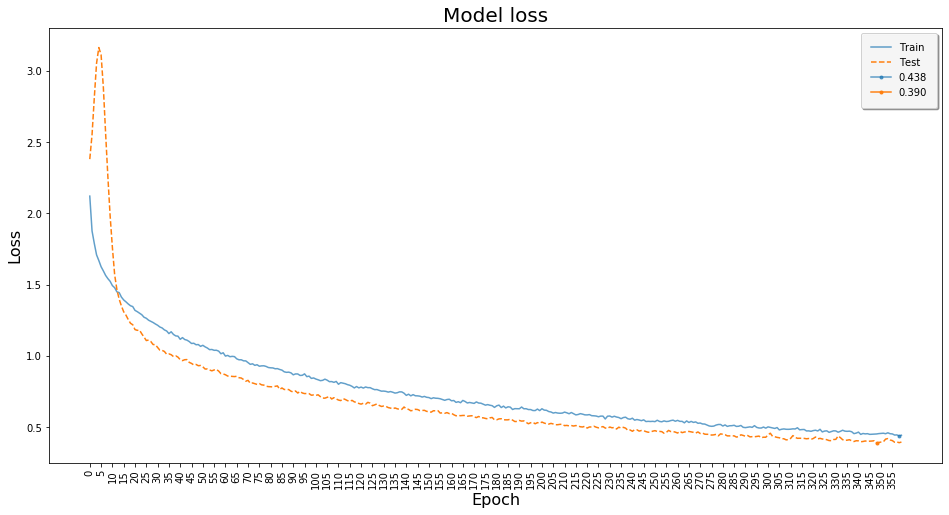

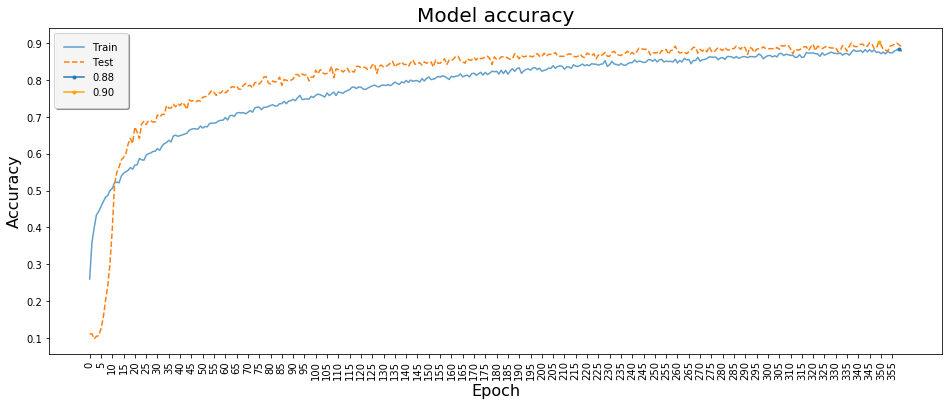

In [12]:
helpers.plot_train_history(history, x_ticks_vertical=True)

Although the shape of the curves are similar to the ones of the previous experiment, the generalization gap is thinner. If we look at the error minimums we also find out that there is a smaller difference between validation and train errors.<br/>
<br/>

### 3. Model evaluation


#### * Register model output

In [27]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

/home/edu/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#### 3.1 Confussion matrix

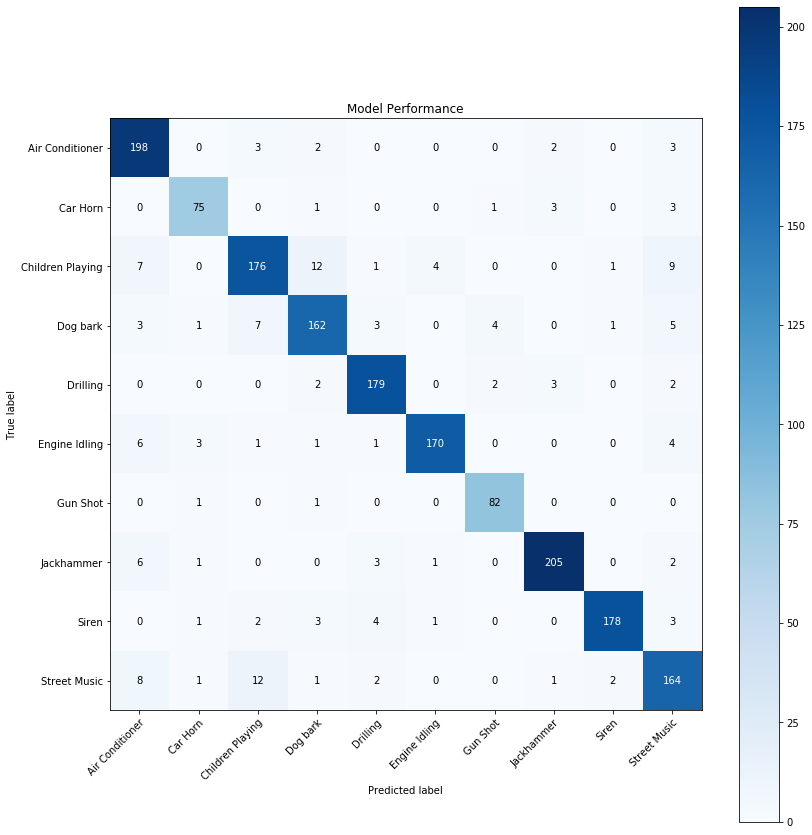

In [28]:
import importlib
importlib.reload(helpers)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

The patterns found on working with MFCC are replicated, but most of the true positives have increased and false negatives have decreased.<br/>
<br/>

#### 3.2 Accuracy table

In [29]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,97.619048
4,Drilling,95.212766
0,Air Conditioner,95.192308
7,Jackhammer,94.036697
8,Siren,92.708333
5,Engine Idling,91.397849
1,Car Horn,90.361446
3,Dog bark,87.096774
9,Street Music,85.863874
2,Children Playing,83.809524


In a similar fashion, most class-accuracies have increased.

#### 3.3 Classification performance: Presicion, Recall and F1 scores

In [30]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.87      0.95      0.91       208
        Car Horn       0.90      0.90      0.90        83
Children Playing       0.88      0.84      0.86       210
        Dog bark       0.88      0.87      0.87       186
        Drilling       0.93      0.95      0.94       188
   Engine Idling       0.97      0.91      0.94       186
        Gun Shot       0.92      0.98      0.95        84
      Jackhammer       0.96      0.94      0.95       218
           Siren       0.98      0.93      0.95       192
    Street Music       0.84      0.86      0.85       191

        accuracy                           0.91      1746
       macro avg       0.91      0.91      0.91      1746
    weighted avg       0.91      0.91      0.91      1746



Scores have increased a bit in average, we still see the same general patterns.
<br/>

### 4. Conclusions

Log scaled Mel Spectrograms did work better than MFCC coefficients in our experiments, as it also happened in some of the papers I referenced. On a different experiment I also used **128** MEL bands (the usual number of bands used on papers that use Mel Spectrograms), in my particular case I didn't notice a difference that could justify processing so many more channels (+88) per sample.<br/>
<br/> 

### 5. Next

We already found out that Mel Spectrograms features work better, now we want to see how much this model can improve if we use augmented data.<br/>
<br/>
<br/>